## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
!{sys.executable} -m pip install gdown h5py

In [3]:
import os
current_dir = os.getcwd()  
root_dir = os.path.abspath(os.path.join(current_dir, '..')) 
sys.path.insert(0, root_dir)

In [4]:
from src.utils import load_it_data, visualize_img
from src.utils_sylvain import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gdown

output = "IT_data.h5"

if not os.path.exists(output):
    url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
    gdown.download(url, output, quiet=False)
    print("Download complete.")
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


### Load the data

In [5]:
path_to_data = '' 
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus, n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [7]:
print("Train set stimuli shape:", stimulus_train.shape)
print("Train set spikes shape:", spikes_train.shape)

Train set stimuli shape: (2592, 3, 224, 224)
Train set spikes shape: (2592, 168)


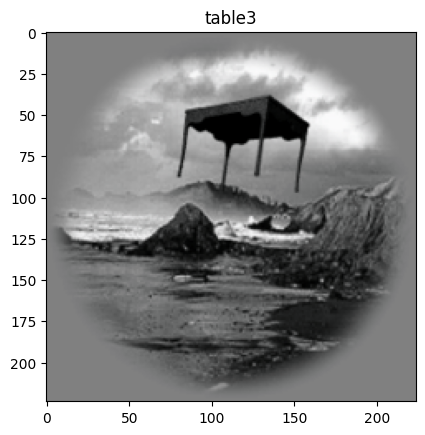

In [8]:
stim_idx = 1
visualize_img(stimulus_train, objects_train, stim_idx)

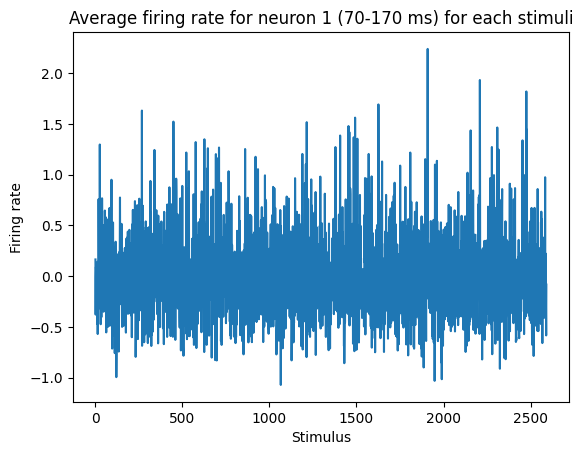

In [9]:
neuron_idx = 1
plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms) for each stimuli'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])
plt.xlabel('Stimulus')
plt.ylabel('Firing rate')
plt.show()

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [10]:
# Define the train and validation sets
X_train = stimulus_train.reshape(n_stimulus, -1)
X_val = stimulus_val.reshape(stimulus_val.shape[0], -1)
y_train = spikes_train
y_val = spikes_val

print("Train set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Train set spikes shape:", y_train.shape)
print("Validation set spikes shape:", y_val.shape)

Train set shape: (2592, 150528)
Validation set shape: (288, 150528)
Train set spikes shape: (2592, 168)
Validation set spikes shape: (288, 168)


In [11]:
# Linear regression 
linear_regression_results = linear_regression('linear', X_train, y_train, X_val, y_val)
print_results("Linear Regression", linear_regression_results)
print(f"Shape of the weights matrix: {linear_regression_results['model'].coef_.T.shape}")

Linear Regression results:
- Mean Squared Error: 0.1429
- R-squared: -0.0374
- Explained Variance: -0.0334
Shape of the weights matrix: (150528, 168)


##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

Averages over neurons:
- Average fraction of explained variance: -0.03
- Average Pearson correlation: 0.22

Evaluation for neuron 120:
- Fraction of explained variance for neuron 120: 0.11
- Pearson correlation for neuron 120: 0.38


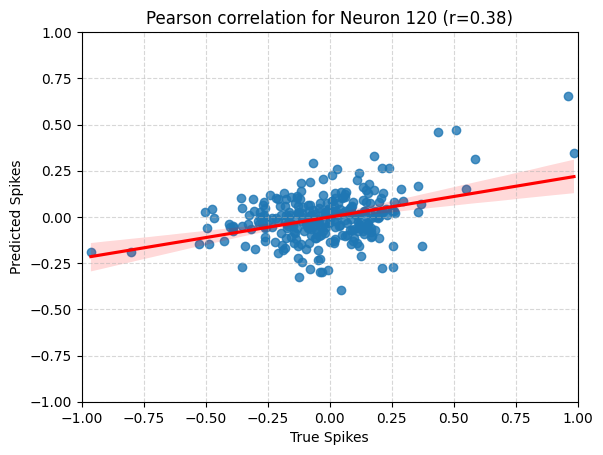

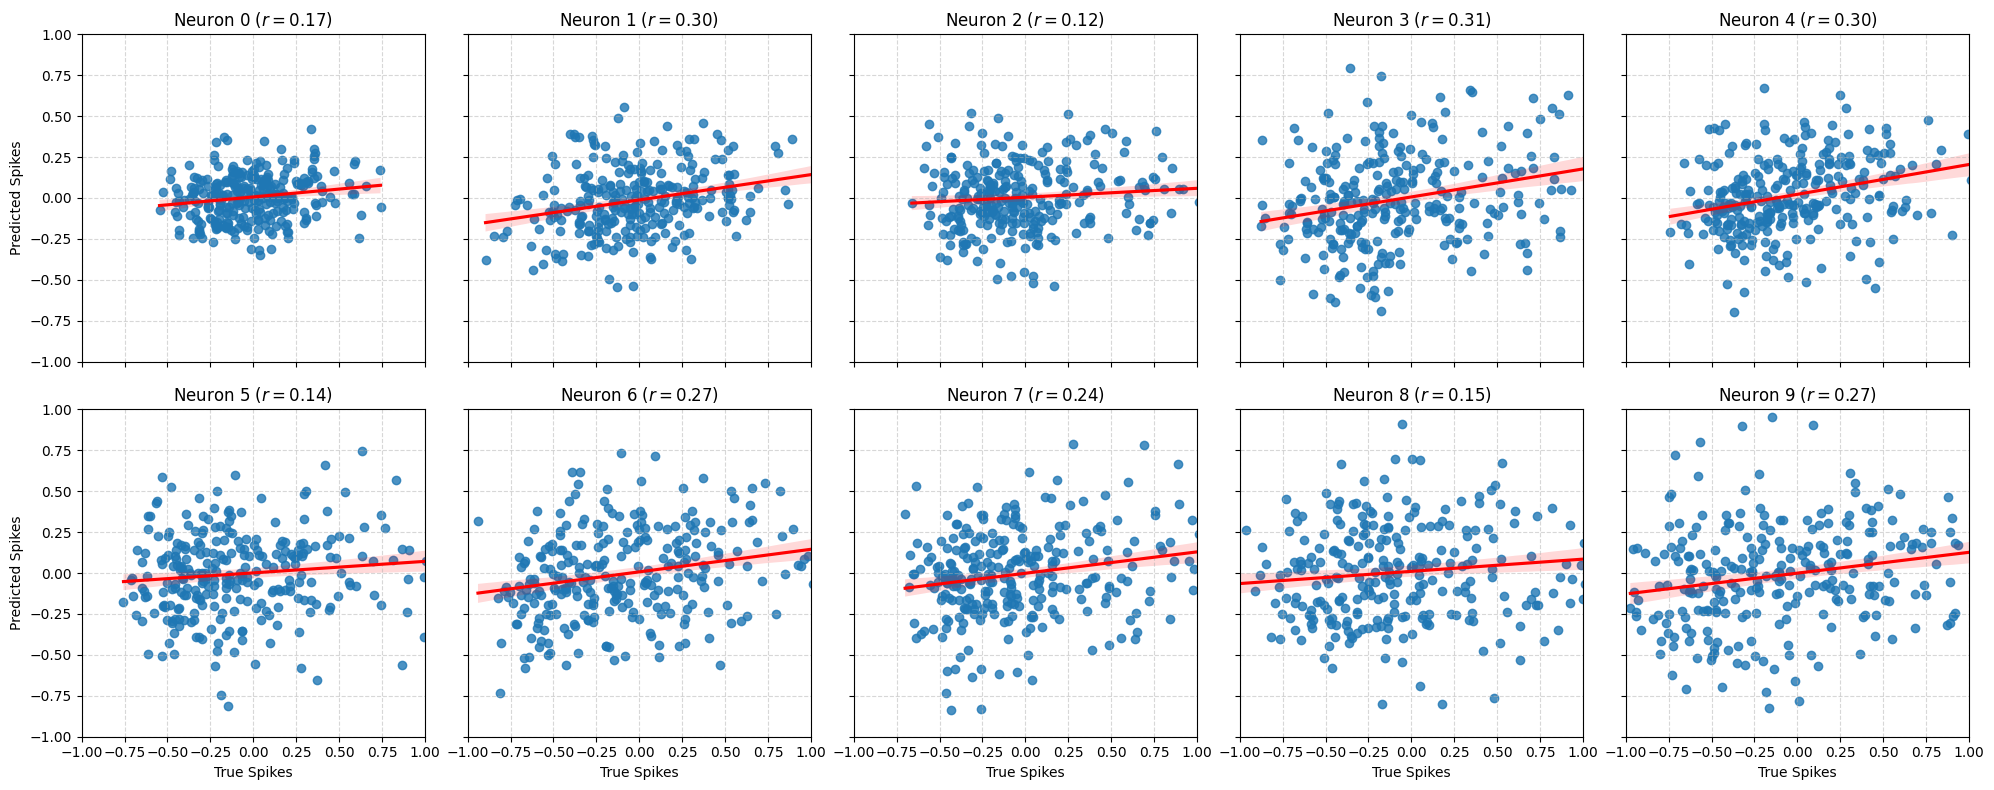

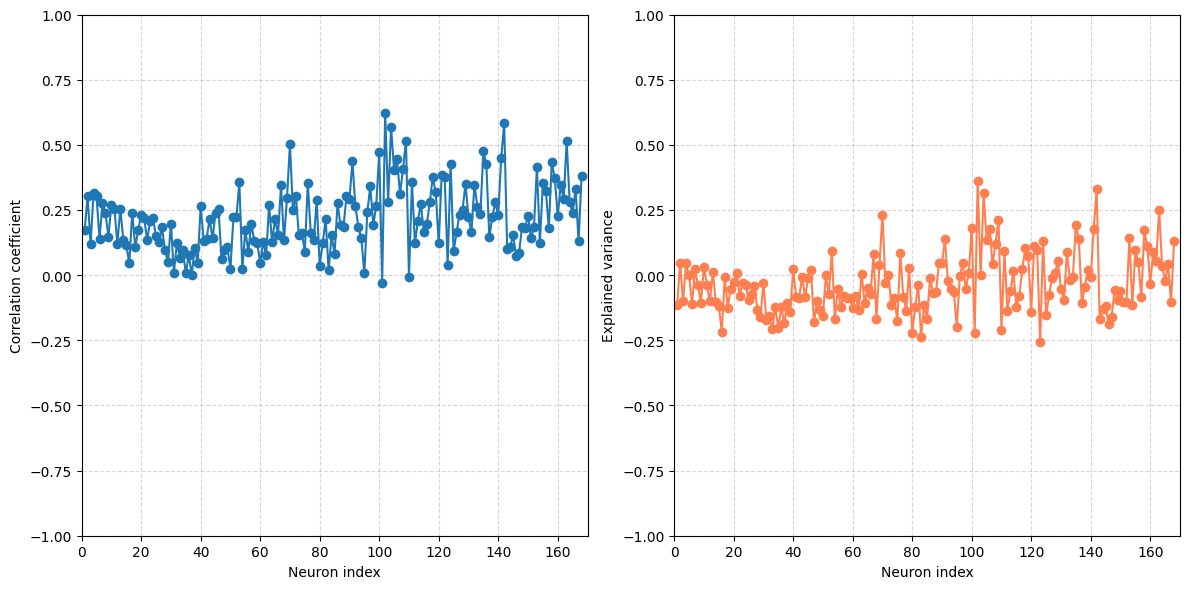

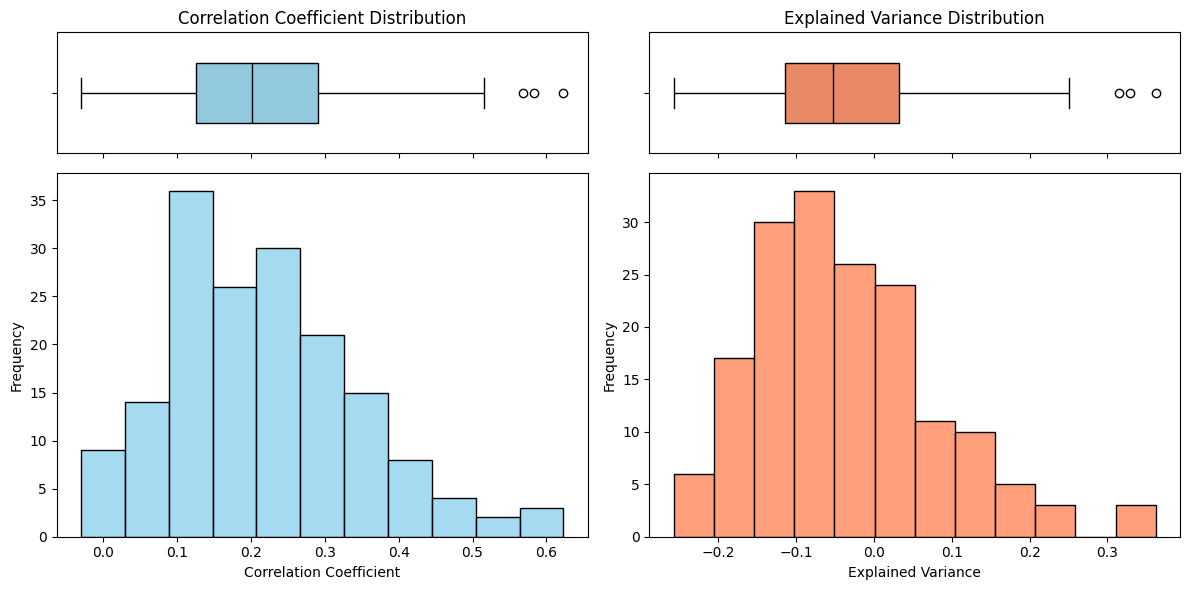

In [13]:
r_values, ev_values = prediction_evaluation(y_val, linear_regression_results["y_pred"]).values()

# Plot the Pearson correlation for a specific neuron
neuron_idx = 120
plot_neuron_evaluation(y_val, linear_regression_results['y_pred'], neuron_idx)

# Plot the Pearson correlation for multiple neurons
neuron_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_multiple_neuron_evaluations(y_val, linear_regression_results['y_pred'], neuron_indices)

# Plot the Pearson correlation and explained variance for individual neurons
plot_corr_ev_by_neuron(r_values, ev_values)

# Distribution of correlation coefficients and explained variances across neurons, boxplot and histogram
plot_corr_ev_distribution(r_values, ev_values)

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [ ]:
# Perform PCA on the training data and transform both X_train and X_val
X_train_pca, X_val_pca = compute_pca(X_train, X_val, n_components=1000)

print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_pca.shape)

In [16]:
results = linear_regression('linear', X_train_pca, y_train, X_val_pca, y_val)
print_results("Linear Regression with PCA", results)

Linear Regression with PCA results:
- Mean Squared Error: 0.1500
- R-squared: -0.0924
- Explained Variance: -0.0883


##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [17]:
# Ridge regression over the unmodified training set
ridge_regression_results = linear_regression('ridge', X_train, y_train, X_val, y_val, alpha_values=[1e6])
print_results("Ridge Regression", ridge_regression_results)

Ridge Regression results:
- Mean Squared Error: 0.1269
- R-squared: 0.0834
- Explained Variance: 0.0876
- Best alpha: 1000000.0


Averages over neurons:
- Average fraction of explained variance: 0.09
- Average Pearson correlation: 0.28

Evaluation for neuron 141:
- Fraction of explained variance for neuron 141: 0.41
- Pearson correlation for neuron 141: 0.65


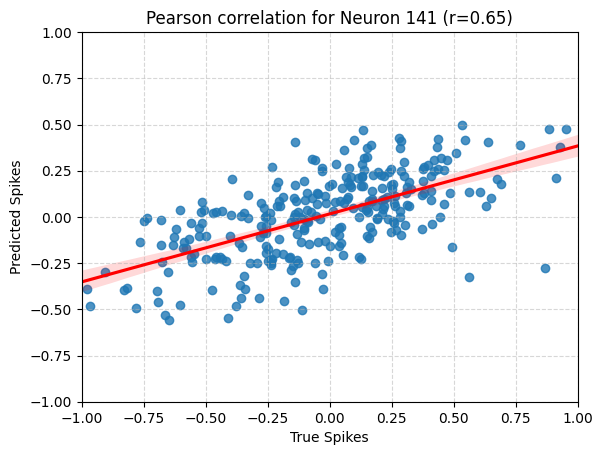

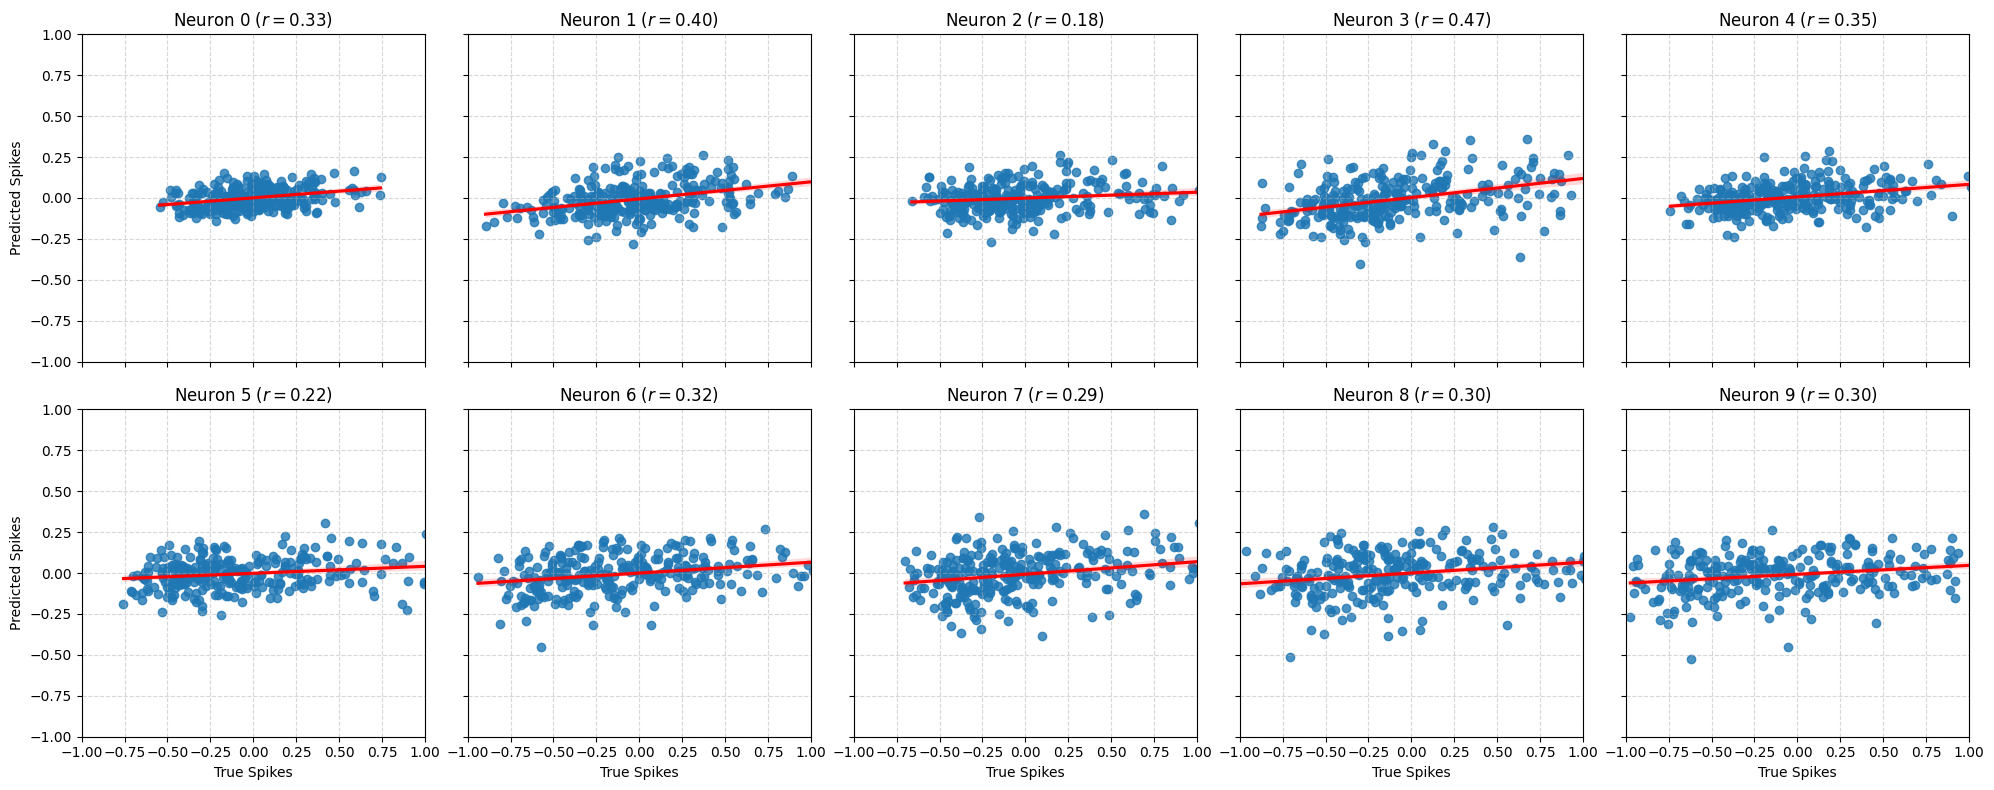

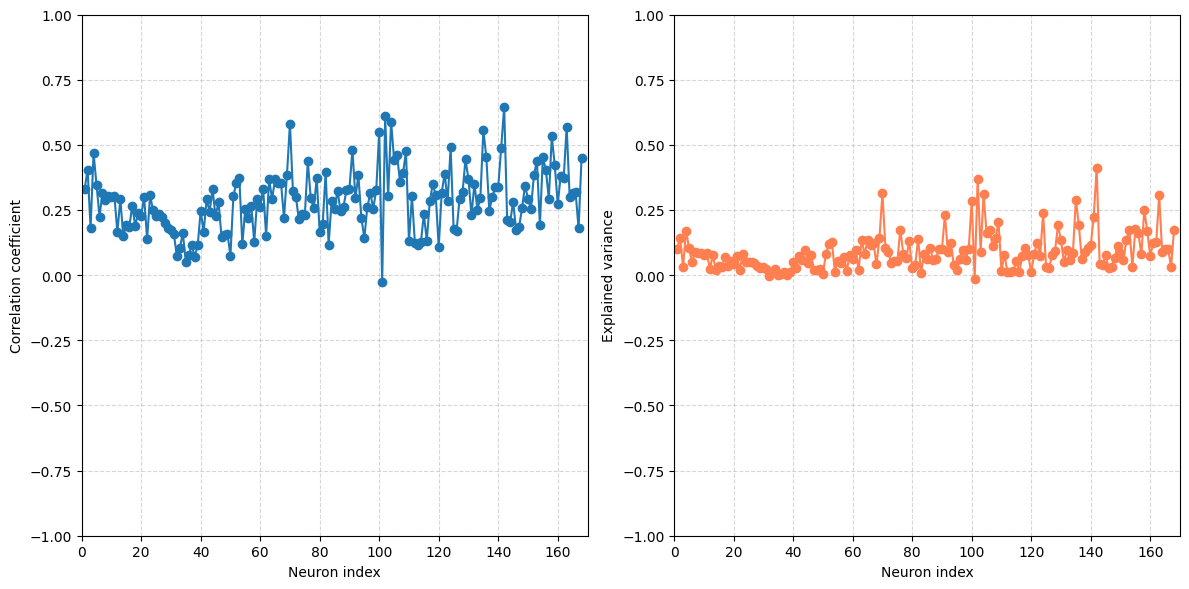

NameError: name 'plot_corr_ev_dist' is not defined

In [18]:
r_values, ev_values = prediction_evaluation(y_val, ridge_regression_results["y_pred"]).values()

# Plot the Pearson correlation for a specific neuron
neuron_idx = np.argmax(r_values)
plot_neuron_evaluation(y_val, ridge_regression_results['y_pred'], neuron_idx)

# Plot the Pearson correlation for multiple neurons
neuron_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plot_multiple_neuron_evaluations(y_val, ridge_regression_results['y_pred'], neuron_indices)

# Pearson correlation and explained variance for individual neurons
plot_corr_ev_by_neuron(r_values, ev_values)

# Distribution of correlation coefficients and explained variances across neurons, boxplot and histogram
plot_corr_ev_dist(r_values, ev_values)

In [ ]:
# Ridge regression over the PCA-reduced training set
ridge_regression_results_pca = linear_regression('ridge', X_train_pca, y_train, X_val_pca, y_val, alpha_values=[1e4, 1e5, 1e6, 1e7])
print_results("Ridge Regression with PCA", ridge_regression_results_pca)
print("\n")
print_results("Ridge Regression without PCA", ridge_regression_results)

Ridge Regression with PCA results:
- Mean Squared Error: 0.1269
- R-squared: 0.0830
- Explained Variance: 0.0873
- Best alpha: 1000000.0


Ridge Regression without PCA results:
- Mean Squared Error: 0.1269
- R-squared: 0.0834
- Explained Variance: 0.0876
- Best alpha: 1000000.0


Keeping the first 1000 components makes the fitting much faster while not significantly affecting performance. 

In [ ]:
# Lasso regression
# lasso_regression_results = linear_regression('lasso', X_train, y_train, X_val, y_val, alpha_values=[1e5, 1e6])
# print_results("Lasso Regression", lasso_regression_results)

In [ ]:
# Elastic Net regression
# elastic_net_regression_results = linear_regression('elastic_net', X_train, y_train, X_val, y_val, alpha_values=[1e5, 1e6], l1_ratio_values=[0.1, 0.5, 0.9])
# print_results("Elastic Net Regression", elastic_net_regression_results)

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [ ]:
#### Here your code